In [41]:
%matplotlib inline
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import re
sns.set(style="whitegrid", color_codes=True)


In [42]:
def add_confidence(row, agg_data):
    data = agg_data[agg_data['id'] == row['id']]
    return data.iloc[0]['label:confidence']


def load_dataset(folder):
    def add_fields(df,iteration):
        df['iteration'] = iteration
        df['domain'] = folder[0].split('-')[0]
        return df
         
    agg_list = []
    full_list = []
    test_list = []
    new_a = re.compile(r'[^>]+(?=:\[OBJECT_A\])')
    new_b = re.compile(r'[^>]+(?=:\[OBJECT_B\])')
    for f in folder:

        iteration = 2 if 'it3' in f else 1
        agg = pd.read_csv('{}/agg.csv'.format(f))
        agg = add_fields(agg,iteration)
        agg['raw_text'] = agg.apply(
        lambda row: BeautifulSoup(row['text_html'], "lxml").text.replace(':[OBJECT_A]', '').replace(':[OBJECT_B]', ''),
        axis=1)
        
        agg['a'] = agg.apply(lambda row:  new_a.findall(row['text_html'])[0], axis=1)
        agg['b'] = agg.apply(lambda row:  new_b.findall(row['text_html'])[0], axis=1)
        
        agg_list.append(agg)
        
        
        full = pd.read_csv('{}/full.csv'.format(f))
        full = add_fields(full,iteration)
        full_list.append(full)
        
        test = pd.read_csv('{}/test.csv'.format(f))
        test = add_fields(test,iteration)
        test_list.append(test)
    return pd.concat(agg_list), pd.concat(full_list), pd.concat(test_list)
   
        

In [43]:
jbt_agg, jbt_full, jbt_test = load_dataset(['jbt-data', 'jbt-data-it2','jbt-data-it3'])
compsci_agg, compsci_full, compsci_test = load_dataset(['compsci-data', 'compsci-data-it2', 'compsci-data-it3'])
brands_agg, brands_full, brands_test = load_dataset(['brands-data-100', 'brands-data-400', 'brands-data-it2', 'brands-data-it3'])

In [64]:
columns = ['id','domain', 'object_a', 'object_b', 'sentence', 'it_1_confidence', 'it_2_confidence', 
           'better_count', 'worse_count','none_count', 'most_frequent_label', 'most_frequent_count', 
           'it_1_judgments', 'it_2_judgments', 'sentence_html']


def add_columns(agg,full):
    df = pd.DataFrame(columns=columns)
    for sid in full['id'].unique():
        better_count = 0
        better_trust = 0
        worse_count = 0
        worse_trust = 0
        none_count = 0
        none_trust = 0
        it_1_judgments = 0
        it_2_judgments = 0
        most_frequent = ''
        f_subset = full[full['id'] == sid]
        for i, f_row in f_subset.iterrows():
            label = f_row['label']
            _iteration = f_row['iteration']
            if _iteration == 1:
                it_1_judgments +=1
            else:
                it_2_judgments += 1
                
            if 'BETTER' == label:
                better_count +=1
                better_trust += f_row['_trust']
            elif 'WORSE' == label:
                worse_count += 1
                worse_trust += f_row['_trust']
            else:
                none_count +=1
                none_trust += f_row['_trust']
        winner = sorted([(better_trust, better_count, 'BETTER'), (worse_trust, worse_count, 'WORSE'),
                         (none_trust, none_count, 'NONE')],reverse=True)
        most_frequent_label = winner[0][2]
        most_frequent_count = winner[0][1]
        
        a_it1 = agg[(agg['id'] == sid) & (agg['iteration'] == 1)]
        a_it2 = agg[(agg['id'] == sid) & (agg['iteration'] == 2)]
        

        if len(a_it1) == 1 and len(a_it2) == 1:
            content = [sid,a_it1.iloc[0]['domain'], a_it1.iloc[0]['a'].capitalize(), a_it1.iloc[0]['b'].capitalize(),a_it1.iloc[0]['raw_text'],
                       a_it1.iloc[0]['label:confidence'],a_it2.iloc[0]['label:confidence'],
                       better_count,worse_count,none_count,most_frequent_label,most_frequent_count,it_1_judgments,it_2_judgments,a_it1.iloc[0]['text_html']]
            df.loc[len(df)] =content
    
    df['judgments'] = df['it_1_judgments'] + df['it_2_judgments']
    it1_c = df['it_1_confidence'] * (df['it_1_judgments']/ df['judgments'])
    it2_c = df['it_2_confidence'] * (df['it_2_judgments']/ df['judgments'])
    df['confidence'] = it1_c+it2_c
    
    df['most_frequent_percentage'] = df['most_frequent_count'] / df['judgments']
    numeric_cols =['confidence', 'most_frequent_count', 'most_frequent_percentage','judgments']
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric)

    
    return df

In [65]:
compsci = add_columns(compsci_agg,compsci_full)

In [66]:
brands = add_columns(brands_agg,brands_full)

In [67]:
jbt = add_columns(jbt_agg,jbt_full)

In [73]:
combi = pd.concat([compsci,brands,jbt])
combi = combi[combi['judgments'] <= 4]

In [74]:
print('All rows: {} Unique: {}'.format(len(combi), len(combi['sentence'])))

All rows: 76 Unique: 76


In [78]:
combi[['object_a', 'object_b','sentence','most_frequent_label']].sample(10)

,object_a,object_b,sentence,most_frequent_label
332,Ford,Toyota,"We have already gotten better trucks from Dodge, Ford, and GM because of Toyota also being in the game.",NONE
202,Nike,Adidas,How many of us know why a given model of Nike is better (worse) than a given pair of Adidas?,NONE
2208,Nissan,Renault,But it still drifts a good deal better than a front-wheel drive car like the Nissan Leaf or Renault ZOE.,NONE
2250,Ford,Bmw,"it's like those auto industry awards from the last decade where the latest mediocre vehicle from Ford wins ""Car of the Year"" but everybody on the voting panel drives a BMW, toyota, or volvo.",WORSE
481,Ibm,Intel,"9-Cell battery in decent shape, gets about 4-5 hours on battery with medium brightness and constant web use Keyboard has almost no shine Palmrest and lid have IBM branding Intel 5100 Wi-Fi 1600x1200 UXGA IPS display, IDtech.",NONE
2028,Nike,Adidas,Dig a bit more & U'll learn that there are lotsa other brands that is better than those 2. & ask experienced runners & U'll proly find that Nike & Adidas won't be the 1st brands they'd recommend.,NONE
2209,Google,Kingston,A :APPLE B: BLUETOOTH C: CHAT D: DOWNLOAD E: EMAIL F: FACEBOOK G: Google H: HP I : IPHONE J : JAVA K: Kingston L :LAPTOP M: MESSENGER N : NERO O : ORKUT P : PICASSA Q : QUICK H : HEAL R: RAM S: SERVER T : TWITTER U: USB V: VISTA W: WIFI X: XP Y: YOUTUBE Z: ZORPIA,NONE
222,Intel,Sony,"full tower, thermaltake 750w ps + 500w ps, asus p5w dh mobo, 2g ram, dual Intel w/thermaltake cooler, asus eax1900xtx vid w/512m, 2 seagate 120g HD, 2 Sony cd/dvd drives, digiwave HDTV cable card.",NONE
2256,Ferrari,Bmw,"Corvette, Porsche, Ferrari, BMW, Audi, Mercedes-Benz SLR, Smart Car.",NONE
446,Ford,Chevrolet,"Now it should be easier to tell the current Ford Fusion, Toyota Camry and Chevrolet SS apart by their shape, not their stickers.",NONE


In [50]:
def dist_plot(data):
    print('Rows {}'.format(len(data)))
    ax = sns.countplot(x="most_frequent_label",order=['BETTER','WORSE','NONE'], data=data);
    for p in ax.patches:  
        ax.annotate('{}'.format(p.get_height()), (p.get_x(), p.get_height()))


Rows 7199


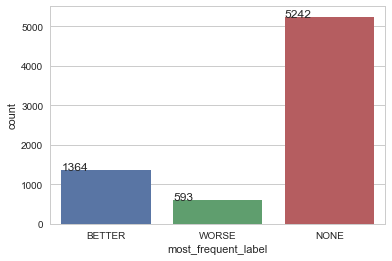

In [51]:
dist_plot(combi)

Rows 2425


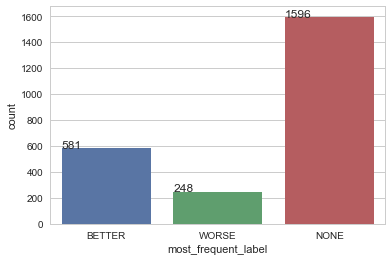

In [52]:
dist_plot(combi[combi.domain == 'compsci'])

Rows 2335


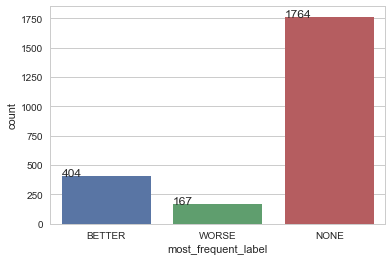

In [53]:
dist_plot(combi[combi.domain == 'brands'])

Rows 2439


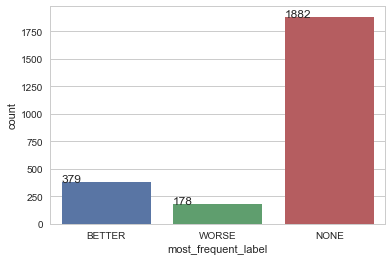

In [54]:
dist_plot(combi[combi.domain == 'jbt'])

In [55]:
from sklearn.model_selection import train_test_split

train_i, test_i = train_test_split(combi,stratify=combi['most_frequent_label'], test_size=0.2,random_state=42)
print('{} {} {}'.format(len(train_i), len(test_i), (len(train_i)+ len(test_i))))
combi.to_csv('all-data.csv',index=False)
train_i.to_csv('data.csv',index=False)
test_i.to_csv('held-out-data.csv',index=False)

5759 1440 7199


In [56]:
from collections import defaultdict
from pprint import pprint

pairs = defaultdict(int)
for i,row in combi[combi.domain == 'jbt'].iterrows():
    p = ' vs. '.join(sorted([row['object_a'].lower(), row['object_b'].lower()]))
    pairs[p] += 1

pprint(pairs)
print(len(pairs))

defaultdict(<class 'int'>,
            {'aluminum vs. metal': 14,
             'aluminum vs. steel': 17,
             'amazon vs. facebook': 18,
             'amazon vs. google': 22,
             'amazon vs. hulu': 26,
             'amazon vs. itunes': 22,
             'amazon vs. youtube': 18,
             'baseball vs. basketball': 17,
             'baseball vs. football': 22,
             'baseball vs. golf': 12,
             'baseball vs. hockey': 12,
             'baseball vs. softball': 24,
             'baseball vs. tennis': 20,
             'basketball vs. football': 19,
             'basketball vs. golf': 20,
             'basketball vs. hockey': 9,
             'basketball vs. softball': 13,
             'basketball vs. tennis': 19,
             'basketball vs. volleyball': 14,
             'beer vs. champagne': 9,
             'beer vs. cider': 16,
             'beer vs. coffee': 12,
             'beer vs. juice': 13,
             'beer vs. milk': 10,
             'beer vs. 

In [57]:
d = defaultdict(int)
for v in combi['most_frequent_percentage']:
    if v == 1:
        d['100'] +=1
    elif v >= 0.8 and v <= 0.99:
        d['80-99'] += 1
    elif v >= 0.6 and v <= 0.79:
        d['60-79'] += 1
    else:
        d['0-50'] += 1

s = sum([v for k,v in d.items()])
print(s)
assert s == len(combi)
res = sorted([(k, v, '{:02.2f}\%'.format(( (v/s) *100 ))) for k,v in d.items()], key=lambda x: x[1],reverse=True)

for r in res:
    print('{}\%\t&\t{}\t&\t{}\t \\\ '.format(r[0], r[1],r[2]))

7199
100\%	&	5111	&	71.00\%	 \\ 
80-99\%	&	1129	&	15.68\%	 \\ 
60-79\%	&	790	&	10.97\%	 \\ 
0-50\%	&	169	&	2.35\%	 \\ 


In [58]:
from IPython.display import display, HTML
pd.set_option('display.max_colwidth', -1)
display(combi[combi.most_frequent_percentage <= 0.5][['sentence','object_a', 'object_b', 'better_count', 'worse_count', 'none_count']])

,sentence,object_a,object_b,better_count,worse_count,none_count
36,"Unlike Windows 7, which provided Microsoft's large user base with an evolutionary path forward from Windows XP, with a look, feel and overall experience that was better - Windows 8 is a different beast.",Windows XP,Windows 8,2,2,1
65,Perl is slower and faster than Java,Perl,Java,2,1,2
121,"Goodnight NetBeans, Hello Eclipse",NetBeans,Eclipse,2,2,1
164,"The new version of the Groovy programming language aims to make life easier for programmers who work with Java and SQL, the language's developers note.",Groovy,Java,3,0,3
196,"This is most likely done to optimize for Integer calculations, rather than slower Floating-point math.",Integer,Floating-point,3,0,3
222,@Slava: FUD! Shameless FUD! Groovy is definitely not thousands times slower than Java!,Groovy,Java,3,1,2
278,This makes JavaScript in my experience harder to debug than Python.,JavaScript,Python,2,4,2
280,The process of converting it to Java resulted in a 100x speed up - despite Perl possibly having a faster regex implementation.,Java,Perl,2,1,2
314,"The GIS functions of MySQL, and even better ones of PostgreSQL, make light work of this, but I started simply.",MySQL,PostgreSQL,3,3,0
325,"CUDA is still strong because it has better support, but we all want OpenCL to win out in the long run (even if they have to update it majorly before that happens)",CUDA,OpenCL,3,2,1
